### 3D City Models from Volunteered Public Data

<div class="alert alert-block alert-warning"><b>This notebook will:</b>

> **1. produce an [interactive *pseudo-3D* Building Model visualization](#Section1)** *- via [pydeck](https://deckgl.readthedocs.io/en/latest/) - which a user can navigate, query, share* **that**;
> > **i) [colour buildings by type](#Section1a)** *(to easily visualize building stock)*  
> > **ii) [includes additional features](#Section1b)** *(parks, bus rapid transit route, etc.)*  
>
> **2. allow the user to execute an application of Spatial Data Science**  
>
>> **i)  [population estimation](#Section2a)** _--with a previous census metric population growth rate and projected (future) population are also possible_  **and**    
>> **ii)  a measure of [Building Volume per Capita](#Section2b).**
>
> **3. propose several [Geography and Sustainable Development Education *conversation starters*](#Section3) for Secondary and Tertiary level students** 

</div>

<div class="alert alert-block alert-danger"><b>Please Note:</b>

***The [village](https://github.com/AdrianKriger/geo3D/tree/main/village)*** processing option is meant for areas with no more than for **2 500 buildings**.</div>

In [1]:
#load the magic

%matplotlib inline
import os
from pathlib import Path
import requests

import overpass
import osm2geojson

import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, shape, mapping
#shapely.speedups.disable()
import json
import geojson
import topojson as tp

import fiona

import city3D

import matplotlib.pyplot as plt
import pydeck as pdk

<a id='Section1'></a>

## 1. Interactive Visualization

**Harvest [OpenStreetMap](https://en.wikipedia.org/wiki/OpenStreetMap)** - Query the [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) from within Jupyter and convert to .geojson.

<div class="alert alert-block alert-info"><b>Set an area-of-interest:</b> 
    
This is done: `large` area -> `focus` area or State (Province) -> Village (neighourhood / campus)
</div>

In [2]:
large = 'Western Cape'
focus = 'Mamre'  
osm_type = 'relation'

In [3]:
query = """
     [out:json][timeout:30];
    // --when areas have duplicate names given the world has a limited amount of uniquely named places
    area[name='{0}'] ->.b;
    // -- target area ~ can be way or relation
    wr(area.b)[name='{1}'];
    map_to_area -> .a;
        // I want all buildings
        (way['building'](area.a);
        // and relation type=multipolygon ~ to removed courtyards from buildings
        relation["building"]["type"="multipolygon"](area.a);
    );
    out count;
    out geom 2500;
    //out body;
    //>;
    //out skel qt;
    """.format(large, focus)#osm_type, focus)

url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})
#rr = r.read()
gj = osm2geojson.json2geojson(r.json())

<div class="alert alert-block alert-danger"><b>NOTICE:</b>

***[village](https://github.com/AdrianKriger/geo3D/tree/main/village)*** will return a maximum of 2 500 buildings in any `focus` area.</div>

In [4]:
#- some print statements
print('')
print(focus, 'has', r.json()['elements'][0]['tags']['ways'], 'buildings')
if int(r.json()['elements'][0]['tags']['ways']) < 2500:
    print('\n\033[1mAll the buildings\033[0m  in', focus, 'have been harvested')
else:
    print('\n', int(r.json()['elements'][0]['tags']['ways'])-2500, "buildings have not been harvested.")

#-- try focus = 'Salt River' to see how a small urban suburb will perform or go over to the Suburb folder


Mamre has 2214 buildings

All the buildings  in Mamre have been harvested


<div class="alert alert-block alert-info"><b></b>


Please do not burden the [OpenStreetMap](https://www.openstreetmap.org/about) server with excessive calls for data.

**If you need to investigate a larger area (> 2 500 buildings); choose *[suburb](https://github.com/AdrianKriger/geo3D/tree/main/suburb)* please.**</div>

In [5]:
# have a look at a random building
gj['features'][2]

{'type': 'Feature',
 'properties': {'type': 'way',
  'id': 328118449,
  'tags': {'building': 'yes', 'building:levels': '1'},
  'nodes': [3349433548, 3349433562, 3349433561, 3349433547, 3349433548]},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[18.4705985, -33.5053849],
    [18.4706523, -33.5056294],
    [18.4705655, -33.5056426],
    [18.4705116, -33.5053982],
    [18.4705985, -33.5053849]]]}}

<div class="alert alert-block alert-warning"><b>Calculate building height:</b> 

We assume a building level is 2.8 meters high and add another 1.3 meters (to account for the roof) and create a new attribute `height`.</div>

The Python code to execute the `.calc_Bldheight` function is in the `city3D.py` script

In [6]:
# -- execute function. calculate building height
#city3D.calc_Bldheight(gj)
#city3D.calc_Bldheight(gj, is_geojson=True)
city3D.calc_Bldheight(gj, is_geojson=True, output_file='./data/fp_j.geojson')

**[pydeck](https://deckgl.readthedocs.io/en/latest/) needs an area and a center**, harvest from osm.

In [7]:
query = """[out:json][timeout:30];
        area[boundary=administrative][name='{0}'] -> .a;
        (
        way[amenity='university'][name='{2}'](area.a);
        {1}[place][place~"sub|town|city|count|state|village|borough|quarter|neighbourhood"][name='{2}'](area.a);
        );
        out geom;
        """.format(large, osm_type, focus)

url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})
#rr = r.read()
area = osm2geojson.json2geojson(r.json())

In [8]:
#area['features'][0]

In [9]:
#read into .gpd
gdf = gpd.GeoDataFrame.from_features(area['features'])

#-- some relation aoi's are many relations ~ extract the 'place' 
if osm_type == 'relation' and len(gdf) > 1:
    gdf.dropna(subset = ["tags"], inplace=True)
    for i, row in gdf.iterrows():
        if row.tags != None and row.tags != np.nan and 'place' in row.tags:
            focus = row
            
    trim = pd.DataFrame(focus)
    trim = trim.T
    gdf = gpd.GeoDataFrame(trim, geometry = trim['geometry'])
        
#gdf = gdf.set_crs(4326)

# -- get the location for pydeck
[xy] = gdf.geometry.centroid
bbox = [gdf.total_bounds[0], gdf.total_bounds[1], 
        gdf.total_bounds[2], gdf.total_bounds[3]]

In [10]:
#xy.x
#gdf

***~ In order to make the most of the semantic data we need to extract the `osm_tags` from the dictionary: and add it as `tooltips` to the visualization.***

<a id='Section1a'></a>
<div class="alert alert-block alert-success"><b>Building Stock:</b> To differentiate a school, formal and informal housing, retail, healthcare and community focused facilities (library, municipal office, community centre) we color the buildings - we harvest the osm tags [building type] directly.</div>

In [11]:
data = './data/fp_j.geojson'
json = pd.read_json(data)
build_df = pd.DataFrame()

# Parse the geometry out to geopandas
gdf = gpd.GeoDataFrame.from_features(json['features'])

build_df["height"] = round(json["features"].apply(lambda row: row["properties"]["building_height"]), 1)
build_df["plus_codes"] = json["features"].apply(lambda row: row["properties"]["plus_code"])

#we want to display data so extract values from the dictionary 
build_df["id"] = json["features"].apply(lambda row: row["properties"]["osm_id"])
build_df["tags"] = json["features"].apply(lambda row: row["properties"])#["osm_tags"])
build_df['levels'] = build_df['tags'].apply(lambda x: x.get('building:levels')).astype(float)

build_df['building'] = build_df['tags'].apply(lambda x: x.get('building'))
build_df['building:use'] = build_df['tags'].apply(lambda x: x.get('building:use'))
build_df['address'] = build_df['tags'].apply(lambda x: x.get('address'))
build_df['building:flats'] = build_df['tags'].apply(lambda x: x.get('building:flats'))
build_df['building:units'] = build_df['tags'].apply(lambda x: x.get('building:units'))
build_df['amenity'] = build_df['tags'].apply(lambda x: x.get('amenity'))
build_df['social_facility'] = build_df['tags'].apply(lambda x: x.get('social_facility'))
build_df['residential'] = build_df['tags'].apply(lambda x: x.get('residential'))
build_df['beds'] = build_df['tags'].apply(lambda x: x.get('beds'))
build_df['rooms'] = build_df['tags'].apply(lambda x: x.get('rooms'))

build_df = gpd.GeoDataFrame(build_df, geometry=gdf.geometry, crs=4326)

In [12]:
#- look
build_df.head(2)

,height,plus_codes,id,tags,levels,building,building:use,address,building:flats,building:units,amenity,social_facility,residential,beds,rooms,geometry
0,4.1,4FRWFFVC+P79,328118446,"{'osm_id': 328118446, 'building': 'yes', 'buil...",1.0,yes,None,None,None,None,None,None,None,None,None,"POLYGON ((18.47060 -33.50579, 18.47070 -33.505..."
1,6.9,4FRWFFVC+H9Q,328118447,"{'osm_id': 328118447, 'building': 'church', 'b...",2.0,church,None,Kerk Street Mamre 7347 Cape Town,None,None,place_of_worship,None,None,None,None,"POLYGON ((18.47092 -33.50592, 18.47093 -33.505..."


In [13]:
# have a look at the building type and amenities available
#df2['bld'].unique()
build_df['building'].unique()

array(['yes', 'church', 'house', 'public', 'civic', 'office', 'retail',
       'clinic', 'school', 'cabin', 'garage', 'greenhouse', 'roof',
       'kindergarten', 'clubhouse', 'service', 'detached', 'shed'],
      dtype=object)

In [14]:
len(build_df)

2187

In [15]:
#- some data wrangling to account for when building:use is different from the original purpose 
#- (building=warehouse now loft apartments or =church now office, etc.)
df2 = build_df.copy()
df_res = build_df[build_df['building:use'] == 'residential']
#df_res = df2[df2['building:use'] != None]
df_res = df_res[~df_res['building:use'].isna()]
df2.loc[df_res.index, 'building'] = df_res['building:use'] 

In [16]:
#build_df.plot()

In [17]:
# colour buildings based on use / amenity
def color(bld):
    #- formal house
    if bld == 'house' or bld == 'semidetached_house' or bld == 'terrace': #- add maisonette, duplex, etc. 
        return [255, 255, 204]                        #-grey
    if bld == 'apartments':
        return [252, 194, 3]                          #-orange 
    #- informal structure / social housing / student
    if bld == 'residential' or bld == 'dormitory' or bld == 'cabin':
        return [119, 3, 252]                          #-purple
        
    if bld == 'garage' or bld == 'parking':
        return [3, 132, 252]                          #-blue        
    if bld == 'retail' or bld == 'supermarket':
        return [253, 141, 60]
    if bld == 'office' or bld == 'commercial':
        return [185, 206, 37]
    if bld == 'school' or bld == 'kindergarten' or bld == 'university' or bld == 'college':
        return [128, 0, 38]
    if bld == 'clinic' or bld == 'doctors' or bld == 'hospital':
        return [89, 182, 178]
    if bld == 'community_centre' or bld == 'service' or bld == 'post_office' or bld == 'hall' or bld == 'civic' \
    or bld ==  'townhall' or bld == 'police' or bld == 'library' or bld == 'fire_station' :
        return [181, 182, 89]
    if bld == 'warehouse' or bld == 'industrial':
        return [193, 255, 193]
    if bld == 'hotel':
        return [139, 117, 0]
    if bld == 'church' or bld == 'mosque' or bld == 'synagogue':
        return [225, 225, 51]
    else:
        return [255, 255, 204]

#build_df["fill_color"] = build_df['combine'].apply(lambda x: color(x))
df2["fill_color"] = df2['building'].apply(lambda x: color(x))

In [18]:
df2.head(2)
#build_df.coordinates[0]

,height,plus_codes,id,tags,levels,building,building:use,address,building:flats,building:units,amenity,social_facility,residential,beds,rooms,geometry,fill_color
0,4.1,4FRWFFVC+P79,328118446,"{'osm_id': 328118446, 'building': 'yes', 'buil...",1.0,yes,None,None,None,None,None,None,None,None,None,"POLYGON ((18.47060 -33.50579, 18.47070 -33.505...","[255, 255, 204]"
1,6.9,4FRWFFVC+H9Q,328118447,"{'osm_id': 328118447, 'building': 'church', 'b...",2.0,church,None,Kerk Street Mamre 7347 Cape Town,None,None,place_of_worship,None,None,None,None,"POLYGON ((18.47092 -33.50592, 18.47093 -33.505...","[225, 225, 51]"


<a id='Section1b'></a>
<div class="alert alert-block alert-success"><b>Additional Features:</b> 
    
To show the potential and power of **3D City Models** we can add additional features to the visualization; *namely: bus rapid transit, parks, agricultural land and waterways (streams). We get this from [OpenStreetMap](https://en.wikipedia.org/wiki/OpenStreetMap) as well.*.</div>

In [19]:
query = """[out:json][timeout:30];
            // --main area
            area[name='{0}']->.b;
           // -- target area ~ can be way or relation
           {1}(area.b)[name='{2}'];
           map_to_area -> .a;
           (
           // query
           way["sport"](area.a);
           way['leisure'="park"](area.a);
           );
           // print results
           out geom;
           //out body;
           //>;
           //out skel qt;
           """.format(large, osm_type, focus)

#url = "http://overpass-api.de/api/interpreter"
p = requests.get(url, params={'data': query})
#rr = r.read()
green_spaces = osm2geojson.json2geojson(p.json())

query = """[out:json][timeout:30];
            // --main area
            area[name='{0}']->.b;
            // -- target area ~ can be way or relation
            {1}(area.b)[name='{2}'];
            map_to_area -> .a;
            (
            // query
            way['waterway'='stream'](area.a);
            );
            // print results
            out body;
            >;
            out skel qt;""".format(large, osm_type, focus)

#url = "http://overpass-api.de/api/interpreter"
w = requests.get(url, params={'data': query})
#rr = r.read()
water_spaces = osm2geojson.json2geojson(w.json())

query = """[out:json][timeout:30];
        // --main area
        area[name='{0}']->.b;
        // -- target area ~ can be way or relation
        {1}(area.b)[name='{2}'];
        map_to_area -> .a;
        (
        // query
        way['landuse'='farmland'](area.a);
        );
        // print results
        out body;
        >;
        out skel qt;
        """.format(large, osm_type, focus)

url = "http://overpass-api.de/api/interpreter"
f = requests.get(url, params={'data': query})
#rr = r.read()
p_spaces = osm2geojson.json2geojson(f.json())

In [20]:
# the bus route ~~ note we only choose routes with a 'colour' tag
query = """
[out:json][timeout:30];
area[name='{0}'];
// -- target area ~ can be way or relation
// gather results
(
  // query part for: “"bus route"”
  relation["type"="route"]["route"="bus"]['operator'="MyCiTi"]['colour'](area);
);
// print results
out body;
>;
out skel qt;
""".format(large)

url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})
#rr = r.read()
r_lines = osm2geojson.json2geojson(r.json())

In [21]:
# have a look at a random bus route
r_lines['features'][0]['properties']

{'type': 'relation',
 'id': 947075,
 'tags': {'colour': '#AACDD2',
  'from': 'Civic Centre',
  'name': 'Bus A01: Civic Centre – Airport [Suspended]',
  'network': 'Cape Town IRT',
  'operator': 'MyCiTi',
  'public_transport:version': '2',
  'ref': 'A01',
  'route': 'bus',
  'to': 'Airport',
  'type': 'route'}}

In [22]:
# extract path and assign colour ~~ so the visualization matches the official documentation

Rgdf = gpd.GeoDataFrame.from_features(r_lines['features'])
Rgdf = Rgdf.explode(index_parts=True)
def coords(geom):
    return list(geom.coords)
Rgdf['path'] = Rgdf.apply(lambda row: coords(row.geometry), axis=1)

Rgdf['name'] = Rgdf['tags'].apply(lambda x: x.get('name')\
                                    if isinstance(x, dict) else np.nan)
Rgdf['colour'] = Rgdf['tags'].apply(lambda x: x.get('colour', np.nan)\
                                    if isinstance(x, dict) else np.nan)
Rgdf = Rgdf[Rgdf['colour'].notna()]

def hex_to_rgb(h):
    h = h.lstrip("#")
    #h = h.replace('#', '')
    return tuple(int(h[i : i + 2], 16) for i in (0, 2, 4))

Rgdf["colour"] = Rgdf["colour"].apply(hex_to_rgb)

Rgdf.head(3)

type  ...           colour
0 0  relation  ...  (170, 205, 210)
1 0  relation  ...  (170, 205, 210)
  1  relation  ...  (170, 205, 210)

[3 rows x 8 columns]

In [ ]:
## ~ (x, y) - bl, tl, tr, br  ~~ or ~~ sw, nw, ne, se
#area = [[[18.4377, -33.9307], [18.4377, -33.9283], [18.4418, -33.9283], [18.4418, -33.9307]]]
area = [[[bbox[0], bbox[1]], [bbox[0], bbox[3]], 
         [bbox[2], bbox[3]], [bbox[2], bbox[1]]]]

## ~ (y, x)
view_state = pdk.ViewState(latitude=xy.y, longitude=xy.x, zoom=16.5, max_zoom=19, pitch=72, 
                                   bearing=80)

land = pdk.Layer(
    "PolygonLayer",
    #"GeoJsonLayer",
    area,
    #build_df,
    stroked=False,
    # processes the data as a flat longitude-latitude pair
    get_polygon="-",
    get_fill_color=[0, 0, 0, 1],
    #material = True,
    #shadowEnabled = True
)
building_layer = pdk.Layer(
    "PolygonLayer",
    #"GeoJsonLayer",
    df2,
    #id="geojson",
    opacity=0.3,
    stroked=False,
    get_polygon="geometry.coordinates",
    filled=True,
    extruded=True,
    wireframe=False,
    get_elevation="height",
    #get_fill_color="[255, 255, 255]", #255, 255, 255
    get_fill_color="fill_color",
    get_line_color="fill_color",#[255, 255, 255],
    #material = True, 
    #shadowEnabled = True, 
    auto_highlight=True,
    pickable=True,
)
greenspaces_layer =  pdk.Layer(
    "GeoJsonLayer",
    green_spaces,
    opacity=0.5,
    stroked=False,
    filled=True,
    wireframe=True,
    get_fill_color="[14, 140, 58]",
    get_line_color='[14, 140, 58]',
)

water_layer =  pdk.Layer(
    "GeoJsonLayer",
    water_spaces,
    opacity=0.8,
    stroked=False,
    filled=True,
    wireframe=True,
    get_fill_color="[35, 35, 142]",
    get_line_color='[35, 35, 142]',
)

r_layer = pdk.Layer(
    type="PathLayer",
    data=Rgdf,
    get_color='colour', #'[245, 51, 58]',
    #width_scale=20,
    #width_min_pixels=8,
    get_path="path",
    get_width=5,
    auto_highlight=False, # change to True if route query
    pickable=False, # change to True if route query
)
p_layer =  pdk.Layer(
    "GeoJsonLayer",
    p_spaces,
    opacity=0.2,
    stroked=False,
    filled=True,
    wireframe=True,
    get_fill_color="[170, 83, 3]",
    get_line_color='[170, 83, 3]',
)

tooltip = {"html": "<b>Levels:</b> {levels} <br/> <b>Address:</b> {address}\
<br/> <b>Plus Code:</b> {plus_codes} <br/> <b>Building Type:</b> {building}"}

#change the tooltip to show bus routes and comment out the previous
#tooltip = {"html": "<b>Route:</b> {name} <br/>"}

r = pdk.Deck(layers=[greenspaces_layer, p_layer, water_layer, r_layer, building_layer],
             #views=[{"@@type": "MapView", "controller": True}],
             initial_view_state=view_state,
             map_style = 'dark_no_labels', #pdk.map_styles.LIGHT,
             tooltip=tooltip)
#save
r.to_html("./result/interactiveOnly.html")
#r.show()

**on a laptop without a mouse:**

- `trackpad left-click drag-left` and `-right`;
- `Ctrl left-click drag-up`, `-down`, `-left` and `-right` to rotate and so-on and
- `+` next to Backspace zoom-in and `-` next to `+` zoom-out.

**Now you do your community.** ~ If your area needs [OpenStreetMap](https://en.wikipedia.org/wiki/OpenStreetMap)  data and you want to contribute please follow the [Guide](https://wiki.openstreetmap.org/wiki/Beginners%27_guide).

***

<div class="alert alert-block alert-danger"><b>GO FURTHER</b></div>

## 2. Spatial Data Science

<div class="alert alert-block alert-warning"><b>Now that we have a visualization of building stock (buildings colorized by `use`); lets do some basic spatial analysis:</b>  
    
     
- We'll estimate the population, within our area of interest, and then  
- calculate the Building Volume Per Capita (BVPC).
</div>

While estimating population is well documented; recent investigations to **understand overcrowding** have led to newer measurements.  

The most noteable of these is **Building Volume Per Capita (BVPC)** [(Ghosh, T; et al. 2020)](https://www.researchgate.net/publication/343185735_Building_Volume_Per_Capita_BVPC_A_Spatially_Explicit_Measure_of_Inequality_Relevant_to_the_SDGs). BVPC is the cubic meters of building per person. **BVPC tells us how much space one person has per residential living unit** (a house / apartment / etc.). It is ***a proxy measure of economic inequality and a direct measure of housing inequality***. 

BVPC builds on the work of [(Reddy, A and Leslie, T.F., 2013)](https://www.tandfonline.com/doi/abs/10.1080/02723638.2015.1060696?journalCode=rurb20) and attempts to integrate with several **[Sustainable Development Goals](https://sdgs.un.org/goals)** (most noteably: **[SDG 11: Developing sustainable cities and communities](https://sdgs.un.org/goals/goal11)**) and captures the average ***'living space'*** each person has in their home.

<div class="alert alert-block alert-info"><b>These analysis expect the user to have some basic knowledge about the environment under inquiry / investigation</b> </div>

In [24]:
#-- lets have a look at the data we have
df2.head(2)

,height,plus_codes,id,tags,levels,building,building:use,address,building:flats,building:units,amenity,social_facility,residential,beds,rooms,geometry,fill_color
0,4.1,4FRWFFVC+P79,328118446,"{'osm_id': 328118446, 'building': 'yes', 'buil...",1.0,yes,None,None,None,None,None,None,None,None,None,"POLYGON ((18.47060 -33.50579, 18.47070 -33.505...","[255, 255, 204]"
1,6.9,4FRWFFVC+H9Q,328118447,"{'osm_id': 328118447, 'building': 'church', 'b...",2.0,church,None,Kerk Street Mamre 7347 Cape Town,None,None,place_of_worship,None,None,None,None,"POLYGON ((18.47092 -33.50592, 18.47093 -33.505...","[225, 225, 51]"


In [25]:
#--we only want building=house or =apartment or =residential
gdf = df2[df2["building"].isin(['house', 'semidetached_house', 'terrace', 'apartments', 'residential', 'dormitory', 'cabin'])].copy()
gdf.head(2)

,height,plus_codes,id,tags,levels,building,building:use,address,building:flats,building:units,amenity,social_facility,residential,beds,rooms,geometry,fill_color
7,4.1,4FRWFFM9+X98,656840974,"{'osm_id': 656840974, 'building': 'house', 'bu...",1.0,house,None,39 Dove Lane Mamre 7347 Cape Town,None,None,None,None,None,None,None,"POLYGON ((18.46843 -33.51507, 18.46843 -33.515...","[255, 255, 204]"
8,4.1,4FRWFFM9+X9X,656840975,"{'osm_id': 656840975, 'building': 'house', 'bu...",1.0,house,None,37 Dove Lane Mamre 7347 Cape Town,None,None,None,None,None,None,None,"POLYGON ((18.46844 -33.51499, 18.46843 -33.515...","[255, 255, 204]"


<a id='Section2a'></a>

<div class="alert alert-block alert-success"><b>1.  a) Estimate Population:</b> 
    
_(with population growth rate and population projection possible too)_ </div>

In [26]:
#- some data wrangling to replace 'bld:residential' to 'bld:student' if 'residential:student'
gdf2 = gdf.copy()
df_res = gdf2[gdf2['residential'] == 'student']
#df_res = df2[df2['building:use'] != None]
df_res = df_res[~df_res['residential'].isna()]
gdf2.loc[df_res.index, 'building'] = df_res['residential'] 

#- some more data wrangling
with pd.option_context("future.no_silent_downcasting", True):
    #gdf2['levels'] = pd.to_numeric(gdf2['levels'].infer_objects(copy=False))
    #if gdf['flats'] != None:
    gdf2['building:flats'] = pd.to_numeric(gdf2['building:flats'].fillna(0).infer_objects(copy=False))
    gdf2['building:units'] = pd.to_numeric(gdf2['building:units'].fillna(0).infer_objects(copy=False))
    gdf2['beds'] = pd.to_numeric(gdf2['beds'].fillna(0).infer_objects(copy=False))
    gdf2['rooms'] = pd.to_numeric(gdf2['rooms'].fillna(0).infer_objects(copy=False))

print(len(gdf))

1870


In [27]:
#y = gdf2[gdf2['building'] == 'residential']
#y

In [28]:
gdf2.head(2)

,height,plus_codes,id,tags,levels,building,building:use,address,building:flats,building:units,amenity,social_facility,residential,beds,rooms,geometry,fill_color
7,4.1,4FRWFFM9+X98,656840974,"{'osm_id': 656840974, 'building': 'house', 'bu...",1.0,house,None,39 Dove Lane Mamre 7347 Cape Town,0,0,None,None,None,0,0,"POLYGON ((18.46843 -33.51507, 18.46843 -33.515...","[255, 255, 204]"
8,4.1,4FRWFFM9+X9X,656840975,"{'osm_id': 656840975, 'building': 'house', 'bu...",1.0,house,None,37 Dove Lane Mamre 7347 Cape Town,0,0,None,None,None,0,0,"POLYGON ((18.46844 -33.51499, 18.46843 -33.515...","[255, 255, 204]"


In [29]:
#len(gdf2)
#gdf2.levels.unique()
#df = gdf2[gdf2['bld'].str.contains('student')] 
#df.levels.dtype
gdf2['building'].value_counts()

building
house    1628
cabin     242
Name: count, dtype: int64

**This area is urban with single level housing units. To estimate population is thus pretty straight forward.**

<div class="alert alert-block alert-info"><b>We start with local knowledge.</b></div>

**On average there are roughly `6` people per `building:house` in this area.**  

An ***informal*** structure ([shack](https://en.wikipedia.org/wiki/Shack)) is tagged [building:cabin](https://wiki.openstreetmap.org/wiki/Tag:building%3Dcabin) and houses `4` people.

<div class="alert alert-block alert-danger"><b>Your Participation! </b>
    
We will execute the calculation programmatically. **Fill in the relevant variables in the _`cell`_ below** </div>

In [30]:
#- average number of residents per formal house
f_house = 6
#- average number of residents per informal structure
inf_structure = 4

<div class="alert alert-block alert-warning"><b></b>  
    
**Furthermore:**  
    - **[social housing](https://en.wikipedia.org/wiki/Public_housing)** is tagged `building:residential` with the number of occupants iether *the number of informal structure occupants* or `building:flats * inf_structure`  
    - A `social_facility` (carehome, shelter, etc.) harvests the `beds` *'key:value'* pair.  
    - `building:apartments` harvests the `building:flats` *'key:value'* pair *(the number of units)* to calculate `*3` people per apartment.  
    - ***Student accomodation***:  
>    - University owed: is tagged `building:dormitory` with `residential:university` and harvests the `beds` *'key:value'* pair.
>    - Private for-profit: is tagged `building:residential` or `:dormitory` with `residential:student` and then harvests the `building:flats` or `:rooms` *'key:value'* pair *(the number of units)* to calculate `*1` people per apartment; if `level: > 1` else `*3` people in a house share.
    
**The tagging scheme and numbers is based on *how your community is mapped* and local knowledge**
</div>

In [31]:
c = gdf2.columns

def pop(row):
    #- formal house
    if row['building'] == 'house' or row['building'] == 'semidetached_house':
        return f_house
    if row['building'] == 'terrace':
        return row['building:units'] * f_house

    #- informal structure (shack)
    if row['building'] == 'cabin':
        return inf_structure
        
    #- in this case social housing
    if row['building'] == 'residential' and row['social_facility'] == None:# or row['building:use'] == 'residential':
        if row['levels'] > 1 and row['rooms'] != 0:
            return row['rooms']
        if row['levels'] > 1 and row['rooms'] == 0:
            return row['building:flats'] * inf_structure
        else:
            return inf_structure

    #-- social facility [shelter / carehome]
    if row['building'] == 'residential' and row['social_facility'] != None:
        if row['levels'] > 1:
            if row['building:units'] != 0:
                return row['building:units'] * inf_structure
            else: 
                return row['beds']
        else:
            return inf_structure
            
    #- formal apartment
    if row['building'] == 'apartments':
        if row['rooms'] != 0:
            return row['rooms']
        else:
            return int(row['building:flats']) * 3
        
    #- private student residence
    if row['building'] == 'student': 
        if row['levels'] > 1:
            if row['rooms'] != 0:
                return row['rooms']
            else:
                return row['building:flats']
        else:
            return 3
    # university owned student residence
    if row['building'] == 'dormitory' and row['residential'] == 'university':
        if row['levels'] > 1:
            if row['rooms'] != 0:
                return row['rooms']
            if row['beds'] != 0:
                return row['beds']
        else:
            return 3

gdf2['pop'] = gdf2.apply(lambda x: pop(x), axis=1)

est_pop = gdf2['pop'].sum()
print('The estimated population is:', est_pop)

The estimated population is: 10736


**The official [STATSSA 2011 census figure](https://www.statssa.gov.za/?page_id=4286&id=291), for this community, is 9048.**

We can calculate the annual population growth rate using the formula for **[Annual population growth](https://databank.worldbank.org/metadataglossary/health-nutrition-and-population-statistics/series/SP.POP.GROW):**

$$r = \frac{\ln{[\frac{End Population}{Start Population}}]}{n} * 100 = \frac{\ln{[\frac{10 736}{9048}}]}{12} * 100   = 1.43\%$$

<div class="alert alert-block alert-danger"><b>Your Participation! </b>
    

It is possible to execute the calculation programmatically. **Fill in the relevant variables in the _`cell`_ below** </div>

In [32]:
#- previous population
start_population = 9048 #6577#

#- period in years from the previous census
years = 12

In [33]:
#-execute
r = (np.log(est_pop/start_population)/years) * 100
print('population growth rate of approximately:', round(r, 2), '%')

population growth rate of approximately: 1.43 %


To conclude; we can project into the future with a very basic formula to estimate the population _x_-years from now:  

$$p  = P_o * (1 + r)^{t} = p = 10736 * (1 + 0.0143)^{10}  = 12 368$$

<div class="alert alert-block alert-danger"><b>Your Participation! </b>
    
It is possible to execute the calculation programmatically. **Fill in the variables in the _`cell`_ below** </div>

In [34]:
#- period in years from now
years = 10

In [35]:
p = est_pop * (1 + (r/100))**years

print('estimated population', years ,'years from now:', int(p))

estimated population 10 years from now: 12368


<a id='Section2b'></a>

<div class="alert alert-block alert-success"><b>2. ii) Building Volume Per Capita (BVPC):</b></div>

**We first need to check the quality** *---topology---* **of the dataset**

In [36]:
gdf2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<img src="data/proj.png" alt="proj" width="550" align="right"/>

<br>
<br>

**We also need [BVPC](https://www.researchgate.net/publication/343185735_Building_Volume_Per_Capita_BVPC_A_Spatially_Explicit_Measure_of_Inequality_Relevant_to_the_SDGs) in a cubic meter but our data is in Decimal Degrees.**  

We need to convert coordinates from a ***Geographic*** to a local ***Projected*** system.  

<div class="alert alert-block alert-info"><b>To keep this extremely generic (use anywhere) we go with WGS84 / Universal Transverse Mercator (UTM).</b></div>

In [37]:
#- internal geopandas function
gdf2.estimate_utm_crs()  

<Projected CRS: EPSG:32734>
Name: WGS 84 / UTM zone 34S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 18°E and 24°E, southern hemisphere between 80°S and equator, onshore and offshore. Angola. Botswana. Democratic Republic of the Congo (Zaire). Namibia. South Africa. Zambia.
- bounds: (18.0, -80.0, 24.0, 0.0)
Coordinate Operation:
- name: UTM zone 34S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<div class="alert alert-block alert-danger"><b>Your Participation! </b>
    
**Fill in the proper `epsg` in the _`cell`_ below** 
</div>

In [38]:
#- first line above: <Projected CRS: EPSG:xxxxx>
epsg = 32734

In [39]:
#- highlight crossing features (buildings). more buildings = more time
gdf2 = gdf2.to_crs(epsg)

gdf_copy = gdf2.copy()
new_df1 = gdf_copy.loc[gdf_copy.overlaps(gdf_copy.unary_union)].reset_index(drop=True)  #-- perhaps no union?
gdf_copy.drop(gdf_copy.index[gdf_copy['building'] == 'bridge'], inplace = True)
gdf_copy.drop(gdf_copy.index[gdf_copy['building'] == 'roof'], inplace = True)

**Plot**

*Browse the saved `'./data/topologyFig'` at your leisure*

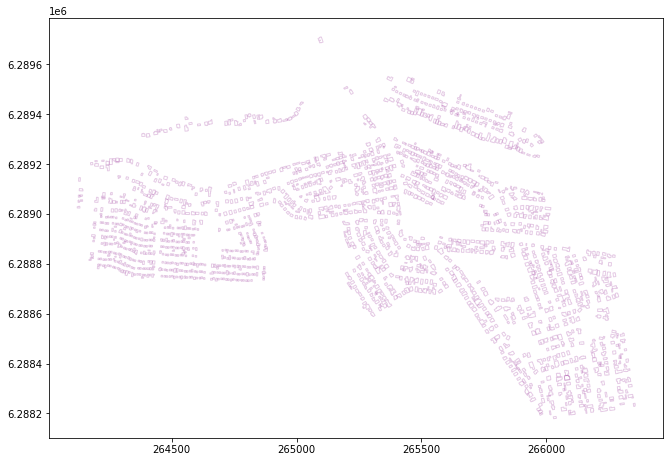

In [40]:
#-plot
fig, ax = plt.subplots(figsize=(11, 11))

gdf_copy.plot(ax=ax, facecolor='none', edgecolor='purple', alpha=0.2)
if len(new_df1) > 0:
    new_df1.plot(ax=ax, edgecolor='red', facecolor='none')#, alpha=0.3)#, column='osm_building', legend=True)

#-- save
plt.savefig('./data/topologyFig', dpi=300)
#plt.show()

|  |  |
|:--------:|:--------:|
| 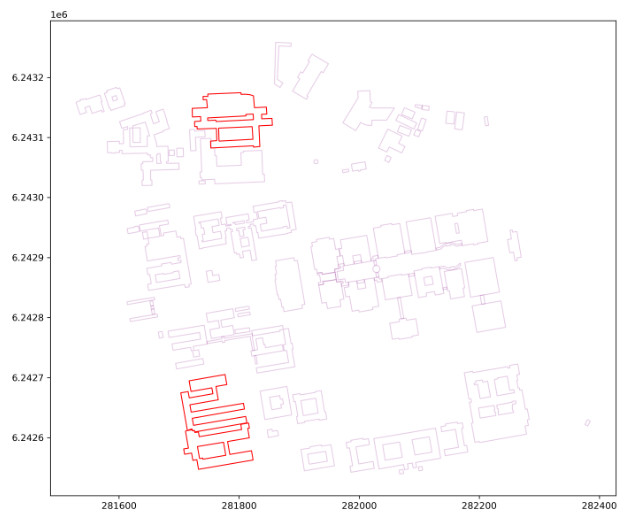| **Challenges will be highlight in *'Red'***|
| 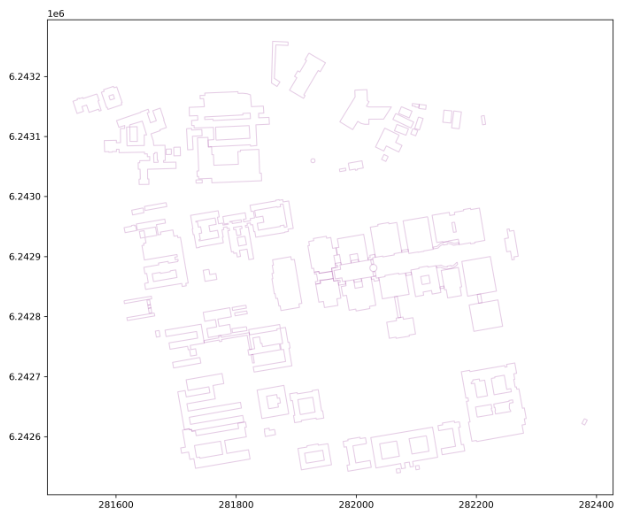| **or none**|

<h2><center> If you continue without fixing the challenges, the BVPC value will not be true.  <br /><br /> Our goal is to be as representative as possible. </center></h2>

**If necessary; edit [OpenStreetMap](https://www.openstreetmap.org/about) and fix the challenge please.** 

<div class="alert alert-block alert-warning"><b>  </b> 

And remember to give the OpenStreetMap server at least a day before attempting the process again.
    
**Alchemy is a process. Please be patient.**
</div>

<div class="alert alert-block alert-success"><b>BVPC = total population of a community divided by sum of building volume</b></div>

In [41]:
#- area and volume
gdf2['area'] = gdf2['geometry'].area
gdf2['volume'] = gdf2['area'] * gdf2['height']

#- remove the volume of the ground floor (unoccupied) when building:levels > 7 [this is an arbitrary number based on local knowledge]
#- typically this space is reserved for some other function: retail, etc. 
gdf2['volume'] = [
    (row['volume'] - row['area'] * 2.8) if (
        row['social_facility'] is None and row['levels'] > 7 and 
        row['building'] in ['residential', 'apartments', 'student']
    ) else row['volume']
    for _, row in gdf2.iterrows()
]
 
gdf2['bvpc'] =  gdf2['volume'] / gdf2['pop'] 

gdf2.tail(2)

,height,plus_codes,id,tags,levels,building,building:use,address,building:flats,building:units,amenity,social_facility,residential,beds,rooms,geometry,fill_color,pop,area,volume,bvpc
2185,4.1,4FRWFFMF+W7J,12289266,"{'osm_id': 12289266, 'building': 'house', 'bui...",1.0,house,None,22 Clarkeson Street Mamre 7347 Cape Town,0,0,None,None,None,0,0,"POLYGON ((265305.077 6288750.422, 265302.872 6...","[255, 255, 204]",6,344.679759,1413.187012,235.531169
2186,4.1,4FRWFFPJ+P7W,12357148,"{'osm_id': 12357148, 'building': 'house', 'bui...",1.0,house,None,2 Tol Street Mamre 7347 Cape Town,0,0,None,None,None,0,0,"POLYGON ((266000.758 6288992.653, 265989.649 6...","[255, 255, 204]",6,327.808101,1344.013215,224.002202


In [42]:
print(gdf2['bvpc'].describe())

count    1870.000000
mean       77.899357
std        50.542538
min        11.821442
25%        37.163535
50%        68.396996
75%       104.641182
max       400.204480
Name: bvpc, dtype: float64


In [43]:
bvpc = round(gdf2['volume'].sum() / est_pop, 3)

print('Building Volume Per Capita (BVPC):', bvpc)

Building Volume Per Capita (BVPC): 79.493


<div class="alert alert-block alert-info"><b></b>

**This BVPC value is general.**  

We can seperate `building:house` from `building:cabin` and `building:residential` to undertand the differences between ***formal and informal*** housing in this area.
    
**We want to understand the living space *(the cubic-meter BVPC value)* each person has in thier home**
</div>

In [44]:
formal = gdf2[gdf2["building"].isin(['house', 'semidetached_house', 'terrace', 'apartment'])].copy()
f_pop = formal['pop'].sum()
#f_area = formal['area'].mean()

informal = gdf2[gdf2["building"].isin(['residential', 'cabin'])].copy()
inf_pop = informal['pop'].sum()
#inf_area = formal['area'].mean()

#- student
stu = gdf2[gdf2["building"].isin(['student', 'dormitory'])].copy()
stu_pop = stu['pop'].sum()

#bvpc_formal = round(formal['volume'].sum() / est_pop, 3)
#bvpc_informal = round(informal['volume'].sum() / est_pop, 3)
#bvpc_stu = round(stu['volume'].sum() / est_pop if est_pop != 0 else 0, 3)

bvpc_formal = round(formal['volume'].sum() / formal['pop'].sum() if formal['pop'].sum() != 0 else 0, 3)
bvpc_informal = round(informal['volume'].sum() / informal['pop'].sum() if informal['pop'].sum() != 0 else 0, 3)
bvpc_stu = round(stu['volume'].sum() / stu['pop'].sum() if stu['pop'].sum() != 0 else 0, 3)

print('FORMAL: Population: ', f_pop, ' with Building Volume Per Capita (BVPC):', bvpc_formal)
print('')
print('STUDENT RESIDENCE: Population: ', stu_pop, ' with Building Volume Per Capita (BVPC):', bvpc_stu)
print('')
print('INFORMAL: Population: ', inf_pop, ' with Building Volume Per Capita (BVPC)', bvpc_informal)

FORMAL: Population:  9768  with Building Volume Per Capita (BVPC): 83.153

STUDENT RESIDENCE: Population:  0  with Building Volume Per Capita (BVPC): 0

INFORMAL: Population:  968  with Building Volume Per Capita (BVPC) 42.558


In [45]:
#stu

<div class="alert alert-block alert-danger"><b>Warning: </b>
    

These are LoD1 3D City Models and works well in these types of areas.  
LoD2 would offer a more representative BVpC [(Ghosh, T; et al. 2020)](https://www.researchgate.net/publication/343185735_Building_Volume_Per_Capita_BVPC_A_Spatially_Explicit_Measure_of_Inequality_Relevant_to_the_SDGs) value; when the complexity of the built environment increases.  

Think about a `house` with living space in the roof structure, so called *'attic living'*, or an `apartment` / `residential` building with different levels, loft apartments and/or units in the turrets of a building. 

***consider***: this area seperates [building:cabin](https://wiki.openstreetmap.org/wiki/Tag:building%3Dcabin) from `building:residential` to more precisely represent informal structures without typical roof trussess but account for [social housing](https://en.wikipedia.org/wiki/Public_housing) that does</div>

***

<div class="alert alert-block alert-warning"><b>  </b>  
    
**To understand the performance in an [Urban setting](https://en.wikipedia.org/wiki/Urban_area) change `cell [2]` above:**

<span style="color:black">**focus**</span> = <span style="color:Darkred">['University Estate'](https://en.wikipedia.org/wiki/University_Estate)</span> <span style="color:black">or</span> <span style="color:Darkred">['Salt River'](https://en.wikipedia.org/wiki/Salt_River,_Cape_Town)</span> <span style="color:black">or</span> <span style="color:Darkred">['Observatory'](https://en.wikipedia.org/wiki/Observatory,_Cape_Town)</span> <span style="color:black">*(with residents per formal house = 4 and residents per informal structure = 3)*</span> <span style="color:black">and</span>  <span style="color:Darkred">'Cape Peninsula University of Technology (Bellville Campus)'</span>       
<span style="color:black">**osm_type**</span> = <span style="color:Darkred">'relation'</span> <span style="color:black">with</span> <span style="color:Darkred">CPUT (Bellville Campus)</span>  <span style="color:black">as</span> <span style="color:Darkred">'way'</span>

</div>

***

**Now you do your community.** ~ If your area needs [OpenStreetMap](https://en.wikipedia.org/wiki/OpenStreetMap) data and you want to contribute please follow the [Guide](https://wiki.openstreetmap.org/wiki/Beginners%27_guide).

<a id='Section3'></a>

<div class="alert alert-block alert-success"><b>3. Possible Secondary and Tertiary level conversations starters:</b></div>

| **Topic**                                | **Secondary Level Questions**                                                                                                                                                                                   | **Tertiary Level Questions**                                                                                                                                                                                                                   |
|------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Geography** | - Talk about the main difference between a globe and a map, and why we use map projections to represent the Earth on a flat surface<br>- Explain why different map projections are used for different purposes. For example, why might a Mercator projection be useful for navigation, but not for comparing the sizes of countries? | - Discuss why it is necessary to convert geographic coordinates (latitude and longitude) to a projected coordinate system in the context of the geospatial sciences. What are some potential issues if this conversion is not done? <br>- How does geodesy contribute to the geospatial sciences?|
| **Basic Understanding and Observations** | - What types of buildings are most common in the area (houses, apartments, retail, etc.)?<br>- Can you identify any patterns in the distribution of different types of buildings (e.g., are retail stores concentrated in certain areas)? | - How does the building stock composition (e.g., ratio of houses) correlate with the population? *demographics (e.g., age distribution, household size) for the area will strengthen the analysis!* <br>- Analyze the relationship between building density and population. What urban planning theories can explain this relationship? |
| **Spatial Relationships and Impacts**    | - How does the location of residential areas compare to the location of retail and commercial areas?<br>- What impact might the density and distribution of buildings have on local traffic and transportation?<br>- How might the population distribution affect the demand for local services such as schools, hospitals, and parks? | - Evaluate the accessibility of essential services (e.g., healthcare, education) in relation to the population and building types.<br>- Assess the potential social and economic impacts of a proposed new residential or commercial development in the area.                  |
| **Socioeconomic and Environmental Considerations** | - Are there any correlations between the types of housing available and the household size? *additional demographics (e.g., income level) for the area will strengthen the analysis!*<br>- How might the current building stock and population influence the local economy? *demographics (e.g., age distribution, household size) for the area will strengthen the analysis!*<br>- What are some potential environmental impacts of the current building distribution, such as green space availability or pollution levels? | - How does the current building stock support or hinder sustainable development goals (e.g., energy efficiency, reduced carbon footprint)?<br>- What strategies could be implemented to increase the resilience of the community to environmental or economic changes?                       |
| **Future Planning and Development**      | - Based on the current building stock and population metrics, what areas might benefit from additional housing or commercial development?<br>- How could urban planners use this information to improve the quality of life in the area?<br>- What changes would you recommend to better balance residential, commercial, and recreational spaces? | - How might different zoning regulations impact the distribution of residential, commercial, and industrial buildings in the future?<br>- Propose urban design solutions that could improve the sustainability and livability of the area, considering both current metrics and future projections. |
| **Quantitative and Qualitative Research** | |- Design a research study to investigate the impact of building type diversity on community wellbeing. What methodologies would you use?<br>- Analyze historical data to understand trends in building development and population growth. How have these trends shaped the current urban landscape?<br>- Conduct a SWOT analysis (Strengths, Weaknesses, Opportunities, Threats) of the area based on the building stock and population metrics. |